### Visualize the `supernova_explosion_128` dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import os

In [2]:
#print the list of paths of files in the training set
set_path = 'train'
paths = sorted(glob.glob(f'data/{set_path}/*.hdf5'))
print(paths)

['data/train/supernova_explosion_Msun_0.1_dim128_file_00.hdf5', 'data/train/supernova_explosion_Msun_0.1_dim128_file_01.hdf5', 'data/train/supernova_explosion_Msun_0.1_dim128_file_02.hdf5', 'data/train/supernova_explosion_Msun_0.1_dim128_file_03.hdf5', 'data/train/supernova_explosion_Msun_0.1_dim128_file_04.hdf5', 'data/train/supernova_explosion_Msun_0.1_dim128_file_05.hdf5', 'data/train/supernova_explosion_Msun_0.1_dim128_file_06.hdf5', 'data/train/supernova_explosion_Msun_0.1_dim128_file_07.hdf5', 'data/train/supernova_explosion_Msun_0.1_dim128_file_08.hdf5', 'data/train/supernova_explosion_Msun_0.1_dim128_file_09.hdf5', 'data/train/supernova_explosion_Msun_0.1_dim128_file_10.hdf5', 'data/train/supernova_explosion_Msun_0.1_dim128_file_11.hdf5', 'data/train/supernova_explosion_Msun_0.1_dim128_file_12.hdf5']


In [3]:
#select the first path (arbitrary choice)
p = paths[10]

#print the first layer of keys
with h5py.File(p,'r') as f:
    print(f.keys())

<KeysViewHDF5 ['boundary_conditions', 'dimensions', 'scalars', 't0_fields', 't1_fields', 't2_fields']>


In [4]:
# In 'boundary_conditions' is stored the information about the boundary conditions:
with h5py.File(p,'r') as f:
    print('print bc available:', f['boundary_conditions'].keys())
    print('print attributes of the bc:', f['boundary_conditions']['x_open'].attrs.keys())
    print('get the bc type:', f['boundary_conditions']['x_open'].attrs['bc_type'])

print bc available: <KeysViewHDF5 ['x_open', 'y_open', 'z_open']>
print attributes of the bc: <KeysViewHDF5 ['associated_dims', 'associated_fields', 'bc_type', 'sample_varying', 'time_varying']>
get the bc type: OPEN


In [5]:
#Reminder: 't0_fields', 't1_fields', 't2_fields' are respectively scalar fields, vector fields and tensor fields
#print the different fields available in the dataset
with h5py.File(p,'r') as f:
    print('t0_fields:', f['t0_fields'].keys())
    print('t1_fields:', f['t1_fields'].keys())
    print('t2_fields:', f['t2_fields'].keys())

t0_fields: <KeysViewHDF5 ['density', 'pressure', 'temperature']>
t1_fields: <KeysViewHDF5 ['velocity']>
t2_fields: <KeysViewHDF5 []>


In [6]:
#The data is of shape (n_trajectories, n_timesteps, x, y,z)
#Get the first t0_field and save it as a numpy array
traj = 3 #select the trajectory as the data is quite big
with h5py.File(p,'r') as f:
    temperature = f['t0_fields']['temperature'][traj,:] #HDF5 datasets can be sliced like a numpy array
    print(f'shape of the selected t0_field: ', temperature.shape)   

shape of the selected t0_field:  (59, 128, 128, 128)


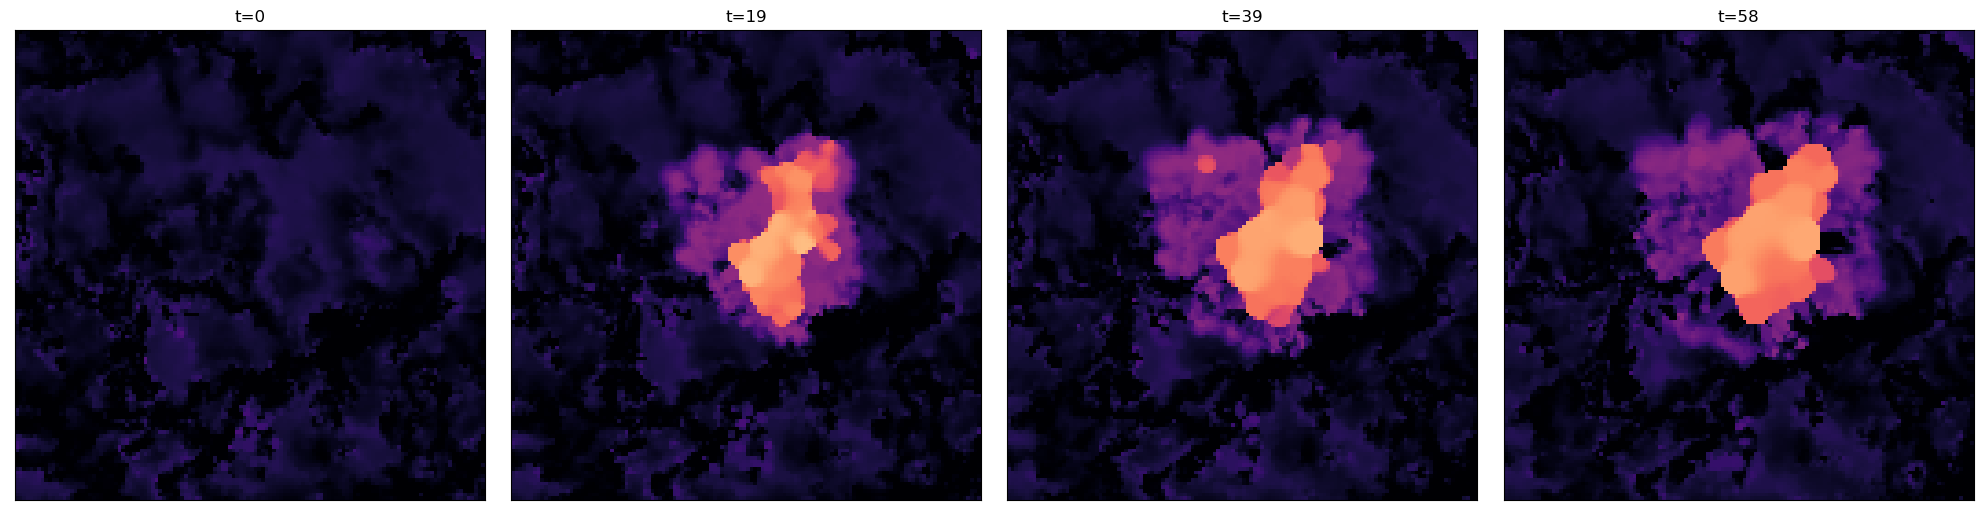

In [8]:
from matplotlib.colors import LogNorm

x_slice = 64 #select the middle slice
traj_toplot = temperature[:, x_slice, :,:]

#field is now of shape (n_timesteps, x, y). Let's do a subplot to plot it at t= 0, t= T/3, t= 2T/3 and t= T:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
T = traj_toplot.shape[0]

#fix colorbar for all subplots:
normalize_plots = True
cmap =  'magma' 

if normalize_plots:
    vmin = np.min(traj_toplot)
    vmax = np.max(traj_toplot)
    norm = LogNorm(vmin=vmin, vmax=vmax)
    for i, t in enumerate([0, T//3, (2*T)//3, T-1]):
        axs[i].imshow(traj_toplot[t], cmap=cmap, norm=norm)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(f't={t}')
else:
    for i, t in enumerate([0, T//3, (2*T)//3, T-1]):
        axs[i].imshow(np.log(traj_toplot[t]), cmap=cmap)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(f't={t}')
plt.tight_layout()




### Visualize the `MHD_256` dataset

### Visualize the `MHD_256` dataset